# WEEK04

## 1、convert audio features into spectrograms and visualize

使用 Librosa 库将音频特征（例如 Mel 频谱图）转换为频谱图，以便作为输入用于 CNN 模型。

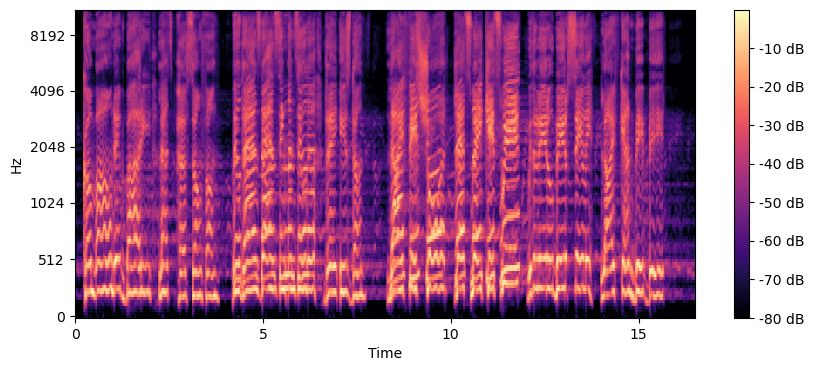

In [12]:
# convert audio features into spectrograms and visualize
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 上传音频
audio_path = '/Users/ninninghe/audioDL/audio_sample/speech_female.wav'
y,sr = librosa.load(audio_path)

# 计算 Mel 频谱图（基于人耳感知的频率范围）
S = librosa.feature.melspectrogram(y=y,sr=sr)

# 将 Mel 频谱图转换为分贝 (dB)
S_dB = librosa.power_to_db(S,ref=np.max)
## 将功率谱转换为分贝 (dB)，增强对比度
## ref=np.max: 参考值，设置为频谱最大值，用于归一化

# 绘制Mel频谱图
plt.figure(figsize=(10,4))
librosa.display.specshow(S_dB,sr=sr,x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB') # 显示颜色条，格式化为分贝 (dB)
plt.show()

## 2、introduction to CNNs

### 2.1 Convolution Layers 卷积层

（1）核心作用：检测图像中的特征，例如边缘、纹理、形状

（2）实现方式: 使用卷积核（filter）对输入图像进行局部扫描和计算，生成特征图（Feature Map）

（3）特点:
- 卷积操作本质是将滤波器（小矩阵）与图像区域点积。
- 提取空间信息的局部相关性。
- 可堆叠多个卷积层，从而捕获更复杂的特征。

### 2.2 Pooling 池化层
（1）核心作用: 减少特征图的大小，降低计算复杂度，避免过拟合。

（2）常见方法:
- 最大池化 (Max Pooling): 选取池化窗口内的最大值。
- 平均池化 (Average Pooling): 计算窗口内像素的平均值。

（3）作用:
- 压缩数据量，减少冗余信息。
- 保留主要特征，增强模型对位移的鲁棒性。

### 2.3 Filters and Depth 滤波器与深度
（1）滤波器作用: 每个滤波器关注不同的特征（例如某一方向的边缘、颜色）。

（2）深度的意义:
- 每层卷积有多个滤波器，特征图的数量等于滤波器的数量。
- 深度越深的网络，提取的特征越抽象。

结合6-7章

## 3、Build a Basic CNN Model and Train It on Spectrograms

In [1]:
# 1、dataset preparation: use saved spectrogram images
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import time

# 数据预处理：转为灰度图像，调整大小，标准化
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转为单通道
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

# 创建自定义数据集 (加载单个图像)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1  # 仅一个样本

    def __getitem__(self, idx):
        image = Image.open(self.image_path)  # 加载图像
        label = 0  # 假设分类为0（仅一个样本，标签可自定义）
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据加载器
image_path = '/Users/ninninghe/audioDL/github_audioDL/weektask/melspectrogram.png'
dataset = CustomDataset(image_path, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 2、bulid the CNN Model in PyTorch
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1) # 单通道、32个滤波器、卷积核大小3*3、步长1、填充1
        self.pool = nn.MaxPool2d(2,2) # 池化窗口大小：2*2、步长2
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1) # 32个通道、64个滤波器、卷积核大小3*3、步长1、填充1
        self.fc1 = nn.Linear(64*32*32,128)
        self.fc2 = nn.Linear(128,10) # 输出层（10分类）分类可调整

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x))) # 卷积层1 + ReLU激活 + 池化
        x = self.pool(torch.relu(self.conv2(x))) # 卷积层2 + ReLU激活 + 池化
        x = x.view(-1,64*32*32) # 拉平成一维，供全连接层使用
        x = torch.relu(self.fc1(x)) # 全连接层1 + ReLU激活
        x = torch.log_softmax(self.fc2(x),dim=1) # 全连接层2 + 归一化
        return x

model = SimpleCNN()

# 3、train the Model:set uo a training loop using a loss function and an optimizer
criterion = nn.CrossEntropyLoss() # 交叉熵
optimizer = optim.Adam(model.parameters(),lr=0.0001) # 优化器

epochs = 5 # 训练次数为5
start_time = time.time()  # 开始计时
for epoch in range(epochs):
    running_loss = 0.0
    for images,labels in trainloader:
        optimizer.zero_grad() # 清零梯度
        outputs = model(images) # 将图像输入到CNN模型里
        loss = criterion(outputs,labels) # 损失函数使用交叉熵，output为实际y，label是理论y
        loss.backward() # 向前传播，梯度下降
        optimizer.step() # 开始梯度下降
        running_loss += loss.item()
    print(f'Epoch{epoch+1},Loss:{running_loss/len(trainloader)}')

# 总训练时间
total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f}s")

Epoch1,Loss:2.243069887161255
Epoch2,Loss:1.3127672672271729
Epoch3,Loss:0.6682059168815613
Epoch4,Loss:0.2871357798576355
Epoch5,Loss:0.11310386657714844
Total Training Time: 0.16s


## 4、Experiment with Different Architectures

### 4.1 增加卷积层：
- 增加网络的深度，例如将卷积层从3层增加到5层。
- 每层可以使用不同的过滤器数量，例如从32个到64个。

In [3]:
# 1、dataset preparation: use saved spectrogram images
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import time

# 数据预处理：转为灰度图像，调整大小，标准化
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转为单通道
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

# 创建自定义数据集 (加载单个图像)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1  # 仅一个样本

    def __getitem__(self, idx):
        image = Image.open(self.image_path)  # 加载图像
        label = 0  # 假设分类为0（仅一个样本，标签可自定义）
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据加载器
image_path = '/Users/ninninghe/audioDL/github_audioDL/weektask/melspectrogram.png'
dataset = CustomDataset(image_path, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 2、bulid the CNN Model in PyTorch
# 增加网络深度，将卷积层从 2 层扩展为 5 层，每层的过滤器数量逐渐增加。
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 第一层
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 第二层
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 第三层
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # 第四层
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  # 第五层
        self.pool = nn.MaxPool2d(2, 2)  # 池化层
        self.fc1 = nn.Linear(512 * 4 * 4, 256)  # 全连接层1
        self.fc2 = nn.Linear(256, 10)  # 全连接层2 (假设10分类)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.pool(torch.relu(self.conv5(x)))
        x = x.view(-1, 512 * 4 * 4)  # 展平为一维
        x = torch.relu(self.fc1(x))
        x = torch.log_softmax(self.fc2(x), dim=1)
        return x

model = DeepCNN()

# 3、train the Model:set uo a training loop using a loss function and an optimizer
criterion = nn.CrossEntropyLoss() # 交叉熵
optimizer = optim.Adam(model.parameters(),lr=0.0001) # 优化器

epochs = 5 # 训练次数为5
start_time = time.time()  # 开始计时
for epoch in range(epochs):
    running_loss = 0.0
    for images,labels in trainloader:
        optimizer.zero_grad() # 清零梯度
        outputs = model(images) # 将图像输入到CNN模型里
        loss = criterion(outputs,labels) # 损失函数使用交叉熵，output为实际y，label是理论y
        loss.backward() # 向前传播，梯度下降
        optimizer.step() # 开始梯度下降
        running_loss += loss.item()
    print(f'Epoch{epoch+1},Loss:{running_loss/len(trainloader)}')

# 总训练时间
total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f}s")

Epoch1,Loss:2.3652491569519043
Epoch2,Loss:2.3062357902526855
Epoch3,Loss:2.256296396255493
Epoch4,Loss:2.19205641746521
Epoch5,Loss:2.1035420894622803
Total Training Time: 0.10s


### 4.2 调整过滤器大小：
- 尝试不同的卷积核大小，例如从 3 * 3 改为 5 * 5。
- 或者在不同的层中使用混合大小的卷积核。

In [5]:
# 1、dataset preparation: use saved spectrogram images
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import time

# 数据预处理：转为灰度图像，调整大小，标准化
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转为单通道
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

# 创建自定义数据集 (加载单个图像)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1  # 仅一个样本

    def __getitem__(self, idx):
        image = Image.open(self.image_path)  # 加载图像
        label = 0  # 假设分类为0（仅一个样本，标签可自定义）
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据加载器
image_path = '/Users/ninninghe/audioDL/github_audioDL/weektask/melspectrogram.png'
dataset = CustomDataset(image_path, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 2、bulid the CNN Model in PyTorch
# 使用混合大小的卷积核，比如第一层使用 3 * 3，第二层使用 5 * 5，第三层使用 7 * 7
class MixedKernelCNN(nn.Module):
    def __init__(self):
        super(MixedKernelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 第一层：3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # 第二层：5x5
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3)  # 第三层：7x7
        self.pool = nn.MaxPool2d(2, 2)  # 池化层
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # 全连接层1
        self.fc2 = nn.Linear(128, 10)  # 全连接层2 (10分类)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # 展平为一维
        x = torch.relu(self.fc1(x))
        x = torch.log_softmax(self.fc2(x), dim=1)
        return x

model = MixedKernelCNN()

# 3、train the Model:set uo a training loop using a loss function and an optimizer
criterion = nn.CrossEntropyLoss() # 交叉熵
optimizer = optim.Adam(model.parameters(),lr=0.0001) # 优化器

epochs = 5 # 训练次数为5
start_time = time.time()  # 开始计时
for epoch in range(epochs):
    running_loss = 0.0
    for images,labels in trainloader:
        optimizer.zero_grad() # 清零梯度
        outputs = model(images) # 将图像输入到CNN模型里
        loss = criterion(outputs,labels) # 损失函数使用交叉熵，output为实际y，label是理论y
        loss.backward() # 向前传播，梯度下降
        optimizer.step() # 开始梯度下降
        running_loss += loss.item()
    print(f'Epoch{epoch+1},Loss:{running_loss/len(trainloader)}')

# 总训练时间
total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f}s")

Epoch1,Loss:2.2538156509399414
Epoch2,Loss:1.9756004810333252
Epoch3,Loss:1.6453744173049927
Epoch4,Loss:1.1930898427963257
Epoch5,Loss:0.6694031357765198
Total Training Time: 0.12s


### 4.3 添加或调整Dropout层：
- 增加Dropout层以减少过拟合。
- 尝试不同的Dropout比例，例如从0.2增加到0.5。

In [7]:
# 1、dataset preparation: use saved spectrogram images
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import time

# 数据预处理：转为灰度图像，调整大小，标准化
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转为单通道
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

# 创建自定义数据集 (加载单个图像)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1  # 仅一个样本

    def __getitem__(self, idx):
        image = Image.open(self.image_path)  # 加载图像
        label = 0  # 假设分类为0（仅一个样本，标签可自定义）
        if self.transform:
            image = self.transform(image)
        return image, label

# 数据加载器
image_path = '/Users/ninninghe/audioDL/github_audioDL/weektask/melspectrogram.png'
dataset = CustomDataset(image_path, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 2、bulid the CNN Model in PyTorch
# 增加 Dropout 层，并尝试不同的 Dropout 比例
class DropoutCNN(nn.Module):
    def __init__(self):
        super(DropoutCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # 添加 Dropout，概率为 0.5
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # 展平为一维
        self.dropout = nn.Dropout(p=0.5)  # Dropout比例为50%，即丢弃神经元的比例
        x = self.dropout(torch.relu(self.fc1(x)))  # 在全连接层前添加 Dropout
        x = torch.log_softmax(self.fc2(x), dim=1)
        return x

model = DropoutCNN()

# 3、train the Model:set uo a training loop using a loss function and an optimizer
criterion = nn.CrossEntropyLoss() # 交叉熵
optimizer = optim.Adam(model.parameters(),lr=0.0001) # 优化器

epochs = 5 # 训练次数为5
start_time = time.time()  # 开始计时
for epoch in range(epochs):
    running_loss = 0.0
    for images,labels in trainloader:
        optimizer.zero_grad() # 清零梯度
        outputs = model(images) # 将图像输入到CNN模型里
        loss = criterion(outputs,labels) # 损失函数使用交叉熵，output为实际y，label是理论y
        loss.backward() # 向前传播，梯度下降
        optimizer.step() # 开始梯度下降
        running_loss += loss.item()
    print(f'Epoch{epoch+1},Loss:{running_loss/len(trainloader)}')

# 总训练时间
total_time = time.time() - start_time
print(f"Total Training Time: {total_time:.2f}s")

Epoch1,Loss:2.2717080116271973
Epoch2,Loss:1.882930040359497
Epoch3,Loss:1.0017002820968628
Epoch4,Loss:0.5708852410316467
Epoch5,Loss:0.2661181390285492
Total Training Time: 0.11s
